# KISS-ICP running on the EDGAR Munich Dataset

<div class="alert alert-block alert-danger">
<b>Note:</b> Currently tested with Datset version 2
</div>


## Expected dataset layout

```sh
munich_dataset_v2
  ├── metadata.yaml
  |── rosbag.db3
```

### Setup

In [10]:

import numpy as np
import math

from copy import deepcopy

from evo.core.trajectory import PosePath3D, PoseTrajectory3D
from evo.tools.file_interface import write_tum_trajectory_file
from scipy.spatial.transform import Rotation as R
from tools.tum_tools import *
from tools.tum_plots import *
from tools.tum_definitions import *

from tools.tum_definitions import KISS_CONFIG as config

from os import path

%load_ext autoreload
%autoreload 2

# %matplotlib inline
%matplotlib widget




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Load the full dataset

# data_root = "/home/julian/projects/thesis/datasets/ext"
data_root = "/home/julian/projects/thesis/datasets/"
gps_data_root =  "/home/julian/projects/thesis/datasets/gps_data"

route = 'mdv3_2'

# Common definitions
pickle_root = f"data/pickle/{route}"

kiss_trajectories = {}

for dataset in Mdv3Dataset:
    kiss_trajectories[dataset.value] = (path.join(data_root, 'converted', route, dataset.value), None, None, None)



In [24]:
# Extract certain keys in case not the full pipeline is to be used
extract_keys = [Mdv3Dataset.FULL_MERGE]
kiss_trajectories = {k:v for k,v in kiss_trajectories.items() if Mdv3Dataset(k) in extract_keys}

### Read Pickle Files

In [ ]:
name="kiss_trajectories_corrected_corr"
kiss_trajectories_corrected = read_pickle(path.join(pickle_root, 'full2', name))

In [ ]:
name="kiss_trajectories"
kiss_trajectories = read_pickle(path.join(pickle_root, 'full2', name))

In [ ]:
# Read GT Pickle File
gt_data = read_pickle(path.join(pickle_root, "full2", "gt_poses"))

### Write Pickle Files

In [ ]:
name="kiss_trajectories_corrected_corr"
write_pickle(path.join(pickle_root, 'full2', name))

In [26]:
name="kiss_trajectories_preprocessed"
write_pickle(kiss_trajectories, path.join(pickle_root, '', name))

In [ ]:
# Write GT Pickle File
write_pickle(gt_data, path.join(pickle_root, "gt_poses"))

### Write to TUM Format

In [9]:
run = 2
fpath_kiss = path.join('data', 'kiss_python', route, 'full_merge', f'run_{run:02d}', 'odometry.tum')
fpath_kiss_uncorrected = path.join('data', 'kiss_python', route, 'full_merge', f'run_{run:02d}', 'odometry_uncorrected.tum')
fpath_gps = path.join('data', 'kiss_python', route, 'full_merge', f'run_{run:02d}', 'gps.tum')
# write_tum_trajectory_file(fpath_kiss, kiss_trajectories_corrected[Mdv3Dataset.FULL_MERGE.value][2])
write_tum_trajectory_file(fpath_kiss_uncorrected, kiss_trajectories[Mdv3Dataset.FULL_MERGE.value][2])
# write_tum_trajectory_file(fpath_gps, gt_data['trajectory'])

### Update Single Data

In [ ]:
update_key = "mdv3_full_merge"

In [ ]:
# TEMPORARY SAVE
tmp_uncorrected = kiss_trajectories[update_key]
tmp_corrected = kiss_trajectories_corrected[update_key]

In [ ]:
# UPDATE
kiss_trajectories[update_key] = tmp_uncorrected
kiss_trajectories_corrected[update_key] = tmp_corrected

### GPS / Ground Truth Data Data

In [4]:
# READ GT POSES

# gt_poses_abs, gt_poses_stamps = load_gt_poses(kiss_trajectories[list(kiss_trajectories.keys())[0]][0], wgsToENU)
gt_poses_abs, gt_poses_stamps = load_gt_poses(path.join(gps_data_root, route), wgsToENU)

gt_poses_t = []
for i in range(len(gt_poses_abs)):
    translation = gt_poses_abs[i]
    
    # Convert quaternion to rotation matrix
    rotation_matrix = np.eye(3)
    
    # Create SE3 transformation matrix
    se3_matrix = np.eye(4)
    se3_matrix[:3, :3] = rotation_matrix
    se3_matrix[:3, 3] = translation
    
    gt_poses_t.append(se3_matrix)
    
gt_poses_stamps = gt_poses_stamps[:len(gt_poses_t)]
gt_poses_se3 = PoseTrajectory3D(poses_se3=gt_poses_t, timestamps=gt_poses_stamps)

gt_data = {
    "abs_poses": gt_poses_abs,
    "translational": gt_poses_t,
    "trajectory": gt_poses_se3,
    "stamps": gt_poses_stamps
}

### Run KISS-ICP

In [20]:
def get_kiss_poses(dataset: dict, gt_poses=None):
    for name, value in dataset.items():
        print(f"Proccesing {name}")
        path = value[0]
        kiss_poses, trajectory_poses, timestamps = run_kiss_icp_pipeline(path, config, gt_poses)
        dataset[name] = (path, kiss_poses, trajectory_poses, timestamps)


In [25]:
# # Run full KISS-ICP Pipeline
get_kiss_poses(kiss_trajectories)

# # Run single KISS-ICP Pipeline
# instance = "mdv3_innovusion_no_merge"
# ds = {instance: kiss_trajectories[instance]}
# get_kiss_poses(ds)


Proccesing mdv3_full_merge
Trying to guess how to read your data: `pip install "kiss-icp[all]"` is required


  0%|          | 0/1177 [00:00<?, ? frames/s]

[WARNING] No GT poses available, skipping evaluation


### KISS-ICP Post-Processing

In [7]:
# Copy for further modification
kiss_trajectories_corrected = deepcopy(kiss_trajectories)

if route == "mdv3_1":
    gt_orientation = 101
elif route == 'mdv3_2':
    gt_orientation = 281
    
# Apply initial heading corrections and put in new dictionary
for ds in kiss_trajectories_corrected.keys():
    data = list(kiss_trajectories_corrected[ds])
    data[2] = align_origin(data[2], yaw_deg=gt_orientation)
    kiss_trajectories_corrected[ds] = tuple(data)

### Plotting

In [ ]:
# Plotting for different Headings

from copy import deepcopy

origin_se3 = np.eye(4)
origin_se3_2 = np.eye(4)
origin_se3[:3,:3] = gt_roation_matrix
origin_se3_2[:3,:3] = gt_roation_matrix2

ref_traj = PosePath3D(poses_se3=[origin_se3])
ref_traj2 = PosePath3D(poses_se3=[origin_se3_2])

kiss_trajectories["mdv3"] = deepcopy(kiss_trajectories["mdv3_sync_merge"])
kiss_trajectories["mdv3_101"] = deepcopy(kiss_trajectories["mdv3_sync_merge"])
kiss_trajectories["mdv3_205"] = deepcopy(kiss_trajectories["mdv3_sync_merge"])
kiss_trajectories["mdv3_101"][2].align_origin(ref_traj)
kiss_trajectories["mdv3_205"][2].align_origin(ref_traj2)

plot_data = {
    "KISS-Poses Uncorrected": kiss_trajectories["mdv3"],
    "KISS-Poses Heading 101°": kiss_trajectories["mdv3_101"],
    "KISS-Poses Heading 205°": kiss_trajectories["mdv3_205"],    
}


fig = plot_trajectories(plot_data, gt_data["abs_poses"])

output_filename = "heading-kiss-poses.pdf"
plt.savefig(f"figures/{output_filename}.pdf", format="pdf", bbox_inches="tight")

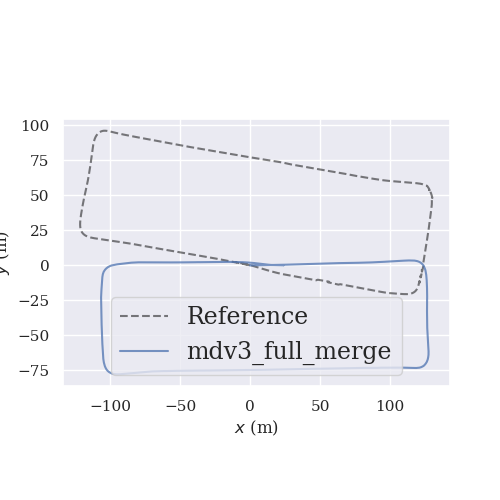

In [66]:
plot_trajectories(kiss_trajectories, gt_data["abs_poses"], figsize=(5,5))

In [ ]:
kiss_trajectories_corrected["reference"] = (None, None, PosePath3D(poses_se3=gt_poses_t))
tmp_dict = {
            "example":kiss_trajectories_corrected["mdv3_ouster_merge"],
            "reference" : kiss_trajectories_corrected["reference"]
            }
plot_trajectories(tmp_dict, gt_poses_abs)
del kiss_trajectories_corrected["reference"]

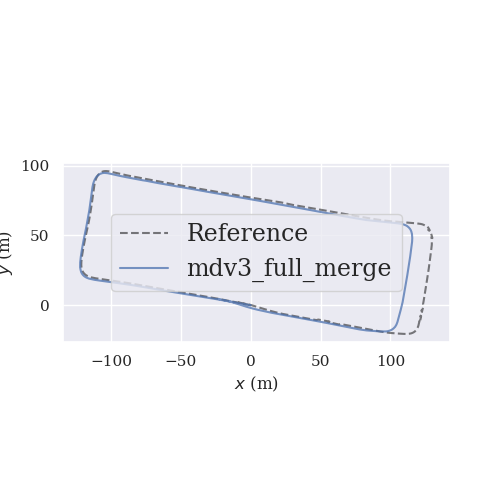

In [74]:
plot_trajectories(kiss_trajectories_corrected, gt_data["abs_poses"], figsize=(5,5))
# plt.savefig("figures/full-compare.pdf", format="pdf", bbox_inches="tight")
